# ECOv003 JET Accuracy Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the JET ensemble using ECOSTRESS Collection 2 Cal-Val data. 

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the JET ensemble, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from ECOv003_L3T_L4T_JET import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Configuration Options

Set configuration options for the notebook, including whether to save plots to files.

In [2]:
# Configuration: Set to True to save plots to files, False to only display them
SAVE_PLOTS = False

In [3]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP_inst_g_m2_s"
]

# Per-variable physical bounds to keep perturbations realistic
input_min = {
    "ST_C": 0.0,
    "NDVI": 0.05,
    "albedo": 0.0,
    "Ta_C": 0.0,
    "RH": 0.0,
    "AOT": 0.0,
    "COT": 0.0,
    "vapor_gccm": 0.0,
    "ozone_cm": 0.0,
    "elevation_m": 0.0,
    "canopy_height_meters": 0.0,
}

input_max = {
    "ST_C": 50.0,
    "NDVI": 1,
    "albedo": 1,
}

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [4]:
forward_process = process_JET_table
model_name = "JET"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [5]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [6]:
input_df = load_ECOv002_calval_JET_inputs()

# Apply lower and upper bounds from configuration dictionaries
mask = pd.Series(True, index=input_df.index)
for var, min_val in input_min.items():
    if var in input_df.columns:
        mask &= input_df[var] >= min_val
for var, max_val in input_max.items():
    if var in input_df.columns:
        mask &= input_df[var] <= max_val

input_df = input_df[mask]
input_df = input_df.dropna()
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,CL,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,2.58,0.4060,0.32,0.14
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,8.48,0.4017,0.29,0.12


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [7]:
processed = forward_process(input_df)
processed

[2026-01-30 10:07:54 INFO] starting JET table processing
[2026-01-30 10:07:54 INFO] started extracting geometry from JET input table
[2026-01-30 10:07:54 INFO] completed extracting geometry from JET input table (0.003 seconds)
[2026-01-30 10:07:54 INFO] started extracting time from JET input table
[2026-01-30 10:07:54 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-01-30 10:07:54 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-01-30 10:07:54 INFO] completed processing FLiES-ANN in 0.15 seconds
[2026-01-30 10:07:54 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:07:54 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 10:07:54 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-01-30 10:07:54 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605 nan: 0.00% (nan)
[2026-01-30 10:0

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones availab

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_daylight_PMJPL_kg,G_PMJPL_Wm2,G_Wm2,LE_instantaneous_Wm2,ET_daylight_kg,ET_uncertainty,GPP_inst_g_m2_s,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,2.783062,24.219544,24.219544,203.764376,2.905500,0.511771,0.000151,0.000058,2.606544,
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,2.758332,13.772918,13.772918,163.144743,2.865325,1.089437,0.000108,0.000034,3.174119,
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,4.112568,33.327163,33.327163,342.564950,4.441287,0.971818,0.000291,0.000122,2.390822,
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,4.424792,42.878466,42.878466,403.011097,4.947307,1.401775,0.000294,0.000211,1.388074,
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,3.891152,2.903704,2.903704,112.556227,3.004434,0.733359,0.000095,0.000015,6.238327,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,3.535094,29.623891,29.623891,397.732265,3.642505,1.045928,0.000233,0.000137,1.697664,
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,3.145096,21.577865,21.577865,285.469147,2.876258,1.138785,0.000138,0.000101,1.357232,
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.695547,77.061858,77.061858,105.892165,1.323042,1.129719,0.000053,0.000016,3.203371,
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.743516,69.968594,69.968594,119.836612,1.411450,1.292735,0.000048,0.000031,1.555148,


## Accuracy Comparison of In-Situ Observations to Model Estimates

Examining the accuracy of model estimates compared to ground data.

analyzing JET accuracy for ET_daylight_kg compared to insitu_ET_daylight_kg


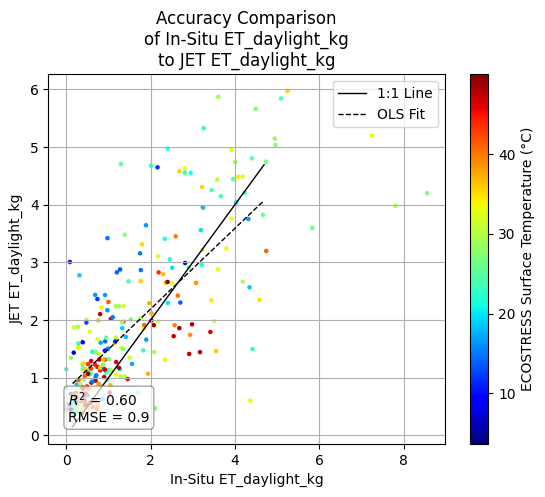

analyzing JET accuracy for G_Wm2 compared to insitu_G_Wm2


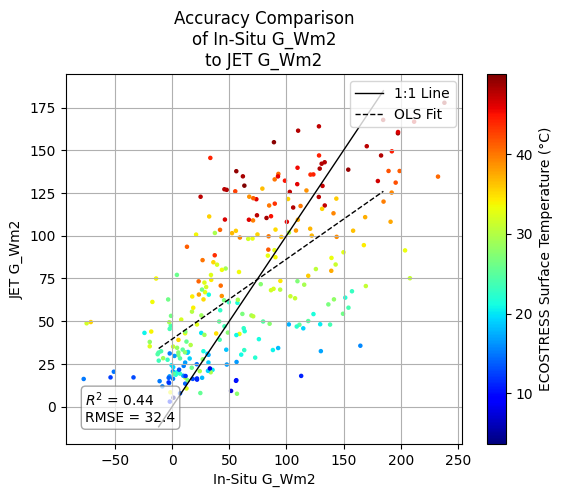

analyzing JET accuracy for H_Wm2 compared to insitu_H_Wm2


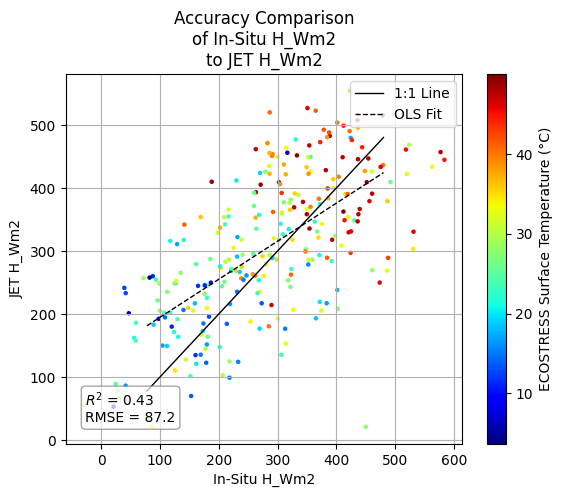

analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2


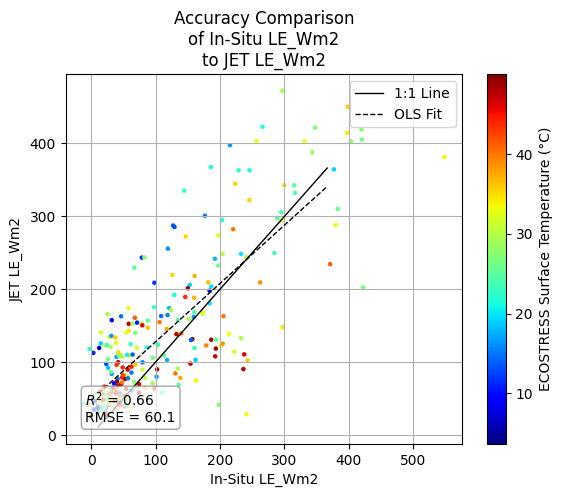

analyzing JET accuracy for LE_daylight_Wm2 compared to insitu_LE_daylight_Wm2
Error processing LE_daylight_Wm2: "['LE_daylight_Wm2'] not in index"
analyzing JET accuracy for Rn_Wm2 compared to insitu_Rn_Wm2


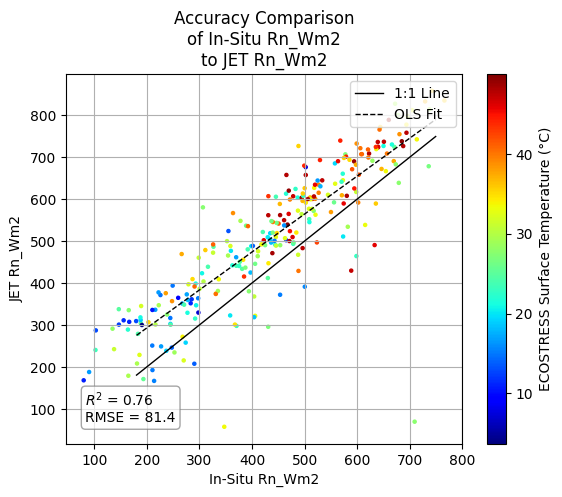

analyzing JET accuracy for Rn_daylight_Wm2 compared to insitu_Rn_daylight_Wm2
Error processing Rn_daylight_Wm2: "['Rn_daylight_Wm2'] not in index"
analyzing JET accuracy for SWin_Wm2 compared to insitu_SWin_Wm2


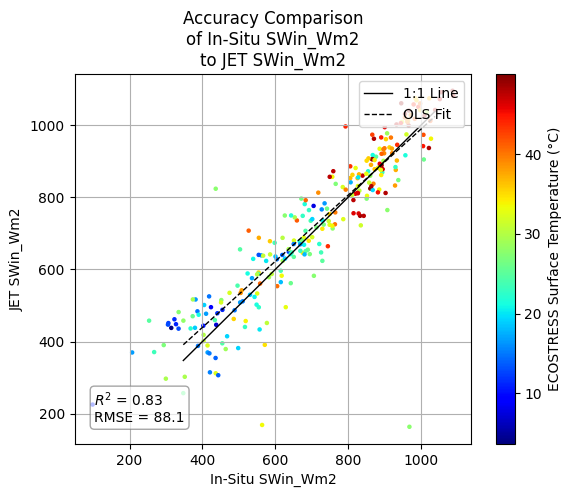

In [8]:
insitu_columns = sorted([column for column in processed.columns if "insitu" in column])

for insitu_variable in insitu_columns:
    try:
        output_variable = insitu_variable.replace("insitu_", "")
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {output_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {output_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        if SAVE_PLOTS:
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.jpeg", format='jpeg', bbox_inches='tight')
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue

# Accuracy Comparison for Net Radiation between BESS and Verma

analyzing JET accuracy for Rn_BESS_Wm2 compared to insitu_Rn_Wm2


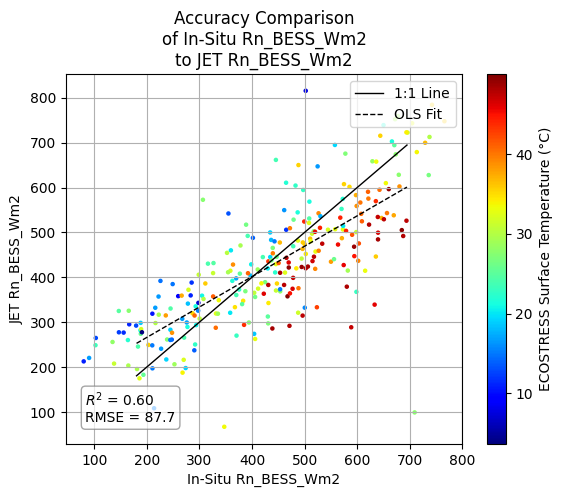

analyzing JET accuracy for Rn_verma_Wm2 compared to insitu_Rn_Wm2


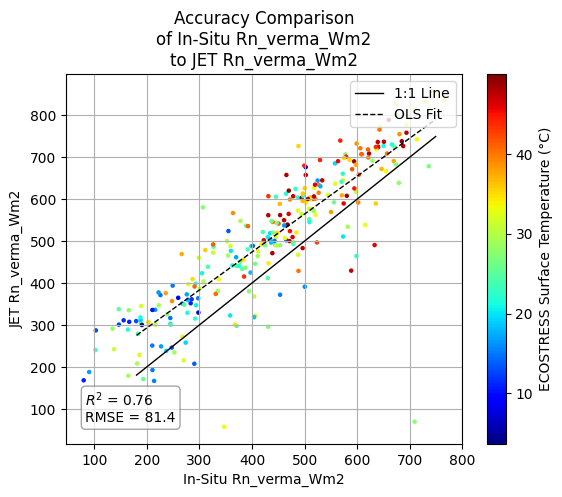

In [9]:
insitu_variable = "insitu_Rn_Wm2"

for output_variable in ["Rn_BESS_Wm2", "Rn_verma_Wm2"]:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {output_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {output_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        if SAVE_PLOTS:
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.jpeg", format='jpeg', bbox_inches='tight')
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue

analyzing JET accuracy for LE_BESS_Wm2 compared to insitu_LE_Wm2


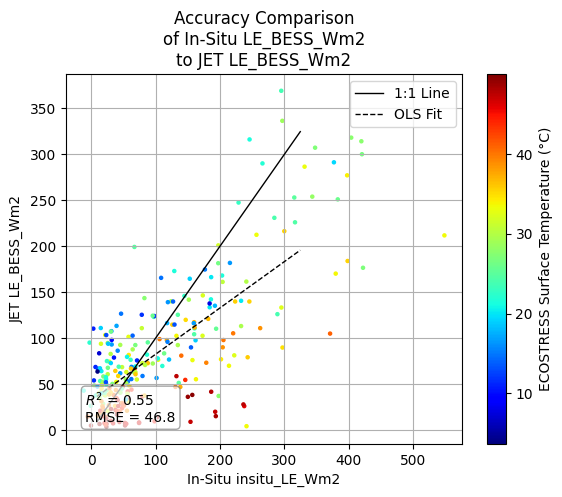

analyzing JET accuracy for LE_STIC_Wm2 compared to insitu_LE_Wm2


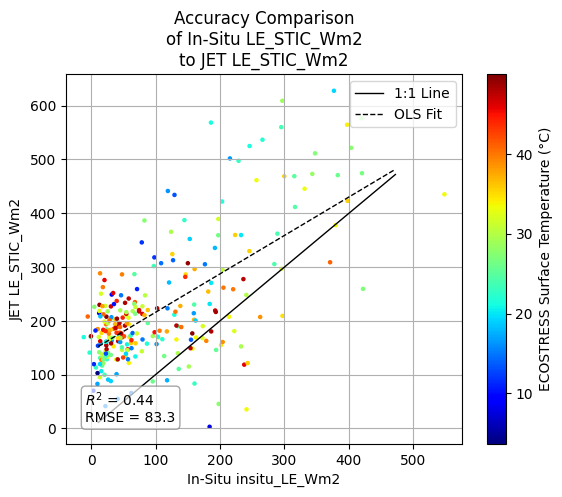

analyzing JET accuracy for LE_PTJPLSM_Wm2 compared to insitu_LE_Wm2


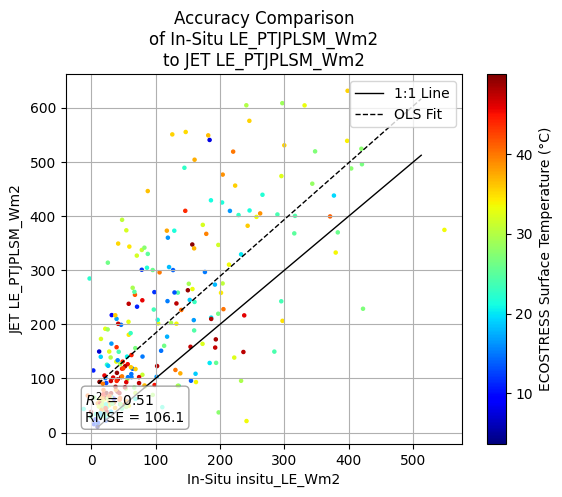

analyzing JET accuracy for LE_PMJPL_Wm2 compared to insitu_LE_Wm2


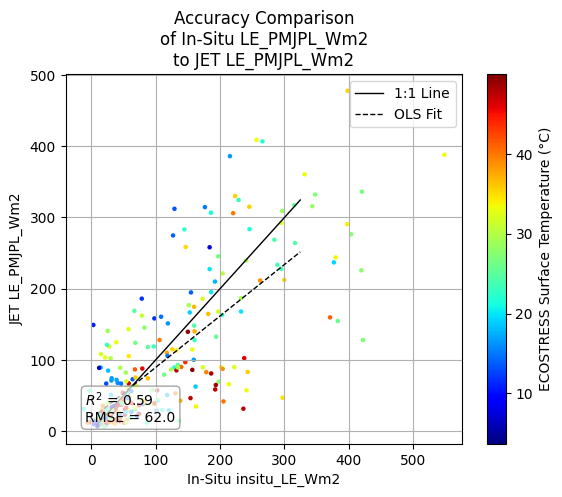

analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2


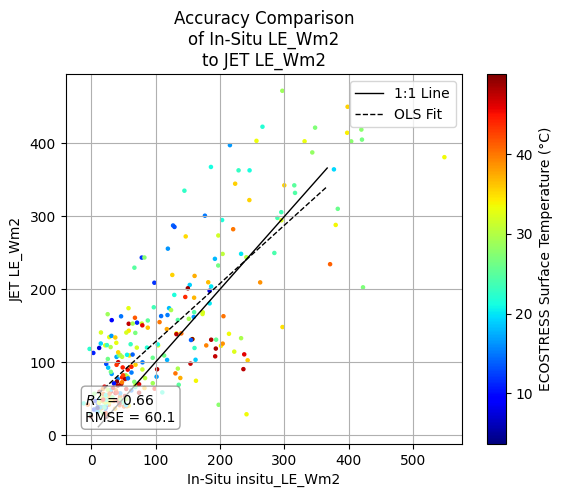

In [10]:
insitu_variable = "insitu_LE_Wm2"

output_variables = [
    "LE_BESS_Wm2",
    "LE_STIC_Wm2",
    "LE_PTJPLSM_Wm2",
    "LE_PMJPL_Wm2",
    "LE_Wm2"
]

for output_variable in output_variables:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {insitu_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {output_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        if SAVE_PLOTS:
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.jpeg", format='jpeg', bbox_inches='tight')
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue


## Plot Unperturbed Comparison of Surface Temperature to Net Radiation

This cell creates a scatter plot comparing ECOSTRESS surface temperature to net radiation for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

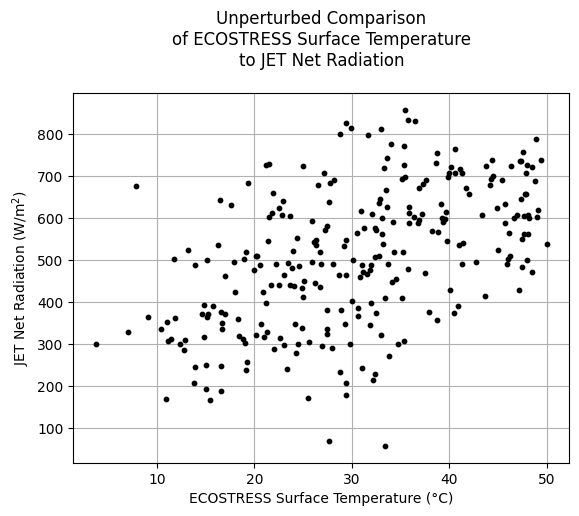

In [11]:
plt.scatter(x=processed.ST_C, y=processed.Rn_Wm2, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Net Radiation (W/m$^2$)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Net Radiation", pad=20)

if SAVE_PLOTS:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

## Plot Unperturbed Comparison of Surface Temperature to Evapotranspiration

This cell creates a scatter plot comparing ECOSTRESS surface temperature to BESS-JPL evapotranspiration for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

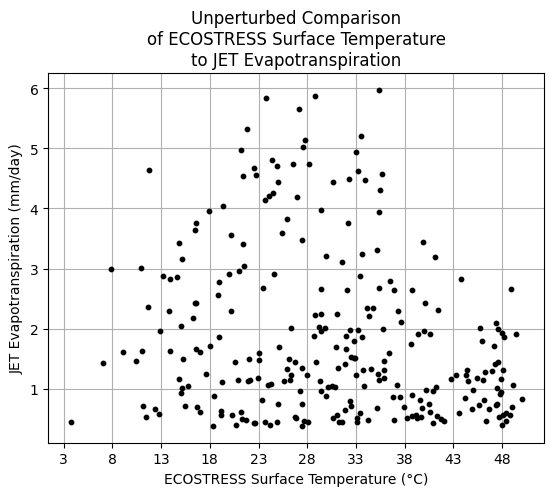

In [12]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.ET_daylight_kg, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Evapotranspiration (mm/day)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Evapotranspiration")

if SAVE_PLOTS:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.show()